# Segmentación y Agrupación de Vecindarios en la Ciudad de México

En este laboratorio aprenderá a convertir direcciones en sus valores equivalentes de latitud y longitud. Además, utilizará la API de FourSquare para explorar los vecindarios de la ciudad de México. Usará la función **explore** para obtener las categorias de lugares mas comunes en cada vecindario, después utilizará esta característica para agrupar los vecindarios en agrupaciones. Usará el algoritmo de agrupamiento *k*-means para completar esta tarea. Finalmente usará la librería Folium para visualizar los vecindarios de la ciudad y sus agrupaciones emergentes.

## Importando Librerías

Antes de obtener los datos y empezar a explorarlos, vamos a descargar todas las dependencias necesarias.

In [37]:
import numpy as np # librería para manejar datos vectorizados

import pandas as pd # librería para análisis de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from collections import Counter

import json # librería para manejar archivos JSON 

#!conda install -c conda-forge geopy --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas

# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

print('Libraries imported.')

Libraries imported.


## Descarga y Exploración del Conjunto de datos

In [38]:
neighborhoods = pd.read_csv('./data_cdmx_planos.csv', encoding='ISO-8859-1')
neighborhoods.tail()

City     Borough                Neighborhood     CP   Latitude  Longitude
106  cdmx     Tláhuac                    San Juan  13030  19.270645 -99.007574
107  cdmx     Tláhuac         San Nicolás Tetelco  13700  19.217623 -98.972601
108  cdmx  Xochimilco                  San Felipe  16770  19.255730 -99.023322
109  cdmx  Xochimilco  San Francisco Tlalnepantla  16900  19.192984 -99.120889
110  cdmx  Xochimilco     Santiago Tepalcatlalpan  16200  19.249188 -99.124952

Y aseguremonos de que el conjunto de datos tiene los 3 alcaldias y los 57 barrios o colonias.

In [39]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 13 boroughs and 111 neighborhoods.


In [40]:
import math
for borough,neighborhood,CP,Latitude in zip(neighborhoods['Borough'],neighborhoods['Neighborhood'],neighborhoods['CP'],neighborhoods['Latitude']):
    if math.isnan(Latitude):
        address = f"{neighborhood} C.P.{CP}, {borough}, CDMX"
        print(address)
        
        geolocator = Nominatim(user_agent="ny_explorer")
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
        except Exception as e:
            print(e)

#### Utilizaremos la librería geopy para obtener la latitud y la longitud de la Ciudad de México

Para poder definir una instancia del geocoder necesitaremos definir un user_agent. Nombraremos a nuestro agente <em>ny_explorer</em>, como se muestra a continuación.

In [41]:
address = 'Mexico City, CDMX'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Mexico City, CDMX are 19.2667063, -99.1269596.


#### Generamos un mapa de CDMX con los barrios super puestos por encima.

In [42]:
# crear un mapa de Nueva York utilizando los valores de latitud y longitud
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=7)

# añadir marcadores al mapa
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
map_cdmx

Ahora vamos a utilizar la API Foursquare para recabar información de cada colonia

In [43]:
headers = {"Accept":"application/json",
          "Authorization":"your api key here"}

In [44]:
# función para extraer la categoria del sitio
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [45]:
def getNearbyVenues(names, latitudes, longitudes, headers, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = "https://api.foursquare.com/v3/places/search"
        search_query=''
        params = {
        "ll": str(lat)+","+str(lng),
        "radius": 500,
        "limit": 50, # 50 son el numero máximo para la version3 de Foursquare aPI
        "sort":"DISTANCE"}
            
        # solicitud GET
        response = requests.request("GET", url, params=params, headers=headers)
        results = response.json()
        results = results['results']

        # regresa solo información relevante de cada sitio cercano
        for venue in results:
                try:
                    venues_list.append([name.strip(), lat,lng, 
                                        venue['name'], 
                                        venue['geocodes']['main']['latitude'],
                                        venue['geocodes']['main']['longitude'],
                                        venue['categories'][0]['name']])
                except Exception as e:
                    venues_list.append([name.strip(), lat,lng, 
                                        venue['name'], 
                                        venue['geocodes']['main']['latitude'],
                                        venue['geocodes']['main']['longitude'],
                                        'Not Especified'])
    print(venues_list)
    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues = pd.DataFrame(venues_list)
    print(nearby_venues)
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Consultamos la información de los 50 lugares registrados de cada colonia

In [46]:
# Corremos la funcion para cada vecindario en la tabla
cdmx_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],headers= headers)

Anzures
Argentina
Bosque de Chapultepec
Bosque de las Lomas
Daniel Garza
Lago Sur
Tacuba
Lomas Altas
Lomas de Chapultepec
Lomas Hermosa
Mexico Nuevo
Pensil
Polanco
Popotla
Reforma Social
San Miguel Chapultepec
Santo Tomas
Tacubaya
Tlaxpana
Atlampa
Santa Maria insurgentes
Peralvillo
Ex-Hipodromo de Peralvillo
Valle Gomez
Maza
Nonoalco Tlatelolco
Morelos
Guerrero
Buenavista
Santa Maria la Ribera
San Rafael
Tabacalera
Cuauhtemoc
Juarez
Roma Norte
Doctores
Obrera
Condesa
Hipodromo Condesa
Hipodromo
Roma Sur
Algarin
Transito
Ampliacion Asturias
Narvarte Poniente
Narvarte Oriente
Del Valle norte
Napoles
Mixcoac
San Pedro de los pinos
del valle centro
del valle sur
Centro (area 1)
Centro (area 2)
Centro (area 3)
Centro (area 4)
Agrícola Pantitlán
Agrícola Oriental
Granjas México
San Pedro
Colina del Sur
El Cuernito
Florida
Jardines del Pedregal
Lomas de La Era
Lomas de Plateros
Lomas de San Ángel Inn
San Ángel
San Bartolo Ameyalco
San Pedro de los Pinos
Santa Rosa Xochiac
Tarango
El Rosario
O

In [47]:
print(cdmx_venues.shape)
cdmx_venues.tail()

(5389, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
5384  Santiago Tepalcatlalpan              19.249188              -99.124952   
5385  Santiago Tepalcatlalpan              19.249188              -99.124952   
5386  Santiago Tepalcatlalpan              19.249188              -99.124952   
5387  Santiago Tepalcatlalpan              19.249188              -99.124952   
5388  Santiago Tepalcatlalpan              19.249188              -99.124952   

                                           Venue  Venue Latitude  \
5384                      Club de Boxeo Santiago       19.248005   
5385                                Queso-burger       19.247841   
5386                       Panadería los Sánchez       19.250790   
5387                       3-28 Birria y Pancita       19.247704   
5388  Biblioteca Pública Santiago Tepalcatlalpan       19.247744   

      Venue Longitude         Venue Category  
5384       -99.126732  Sports and Recreation  
5385       -99.123215             Food Truck  
5386       -99.123543                 Bakery  
5387       -99.123365     Mexican Restaurant  
5388       -99.123291                Library

In [48]:
cdmx_venues = cdmx_venues[cdmx_venues['Venue Category'] != 'Not Especified']

Revisemos el número de lugares encontrados para cada colonia

In [49]:
cdmx_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                     
Agrícola Oriental                                           46   
Agrícola Pantitlán                                          46   
Algarin                                                     50   
Ampliacion Asturias                                         49   
Anzures                                                     50   
Argentina                                                   49   
Atlampa                                                     46   
Bosque de Chapultepec                                       47   
Bosque de las Lomas                                         49   
Buenavista                                                  50   
Campestre Churubusco                                        38   
Centro (area 1)                                             50   
Centro (area 2)                                             50   
Centro (area 3)                                             50   
Centro (area 4)                                             50   
Colina del Sur                                              44   
Condesa                                                     50   
Copilco El Alto                                             49   
Cuajimalpa                                                  49   
Cuauhtemoc                                                  50   
Daniel Garza                                                50   
Del Mar                                                     45   
Del Valle norte                                             47   
Doctores                                                    49   
El Cuernito                                                 37   
El Rosario                                                  50   
Emilio Carranza                                             48   
Ex-Hipodromo de Peralvillo                                  48   
Felipe Ángeles                                              49   
Florida                                                     47   
General Ignacio Zaragoza                                    50   
Granjas México                                              48   
Guerrero                                                    50   
Hipodromo                                                   50   
Hipodromo Condesa                                           50   
Héroes de Churubusco                                        48   
Jardines del Pedregal                                       41   
José López Portillo                                         29   
Juarez                                                      50   
La Venta                                                    42   
Lago Sur                                                    47   
Lomas Altas                                                 35   
Lomas Hermosa                                               49   
Lomas de Chapultepec                                        45   
Lomas de La Era                                             35   
Lomas de Plateros                                           48   
Lomas de San Lorenzo                                        36   
Lomas de San Ángel Inn                                      48   
Lomas de Vista Hermosa                                      37   
Magdalena Mixiuhca                                          48   
Maza                                                        50   
Mexico Nuevo                                                50   
Mixcoac                                                     49   
Morelos                                                     50   
Napoles                                                     50   
Narvarte Oriente                                            49   
Narvarte Poniente                                           50   
Nonoalco Tlatelolco                                         49   
Obrera                                                      49   
Obrero Popular 

Encontremos cuantas categorías únicas de lugares hay en todo el dataframe

In [50]:
print('There are {} uniques categories.'.format(len(cdmx_venues['Venue Category'].unique())))

There are 393 uniques categories.


## Analizando cada colonia

In [51]:
# codificación
cdmx_onehot = pd.get_dummies(cdmx_venues[['Venue Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
cdmx_onehot['Neighborhood'] = cdmx_venues['Neighborhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [cdmx_onehot.columns[-1]] + list(cdmx_onehot.columns[:-1])
cdmx_onehot = cdmx_onehot[fixed_columns]

cdmx_onehot.head()

Neighborhood  Accounting and Bookkeeping Service  Adult Store  \
0      Anzures                                   0            0   
1      Anzures                                   0            0   
2      Anzures                                   0            0   
3      Anzures                                   0            0   
4      Anzures                                   0            0   

   Advertising Agency  Agriculture and Forestry Service  \
0                   0                                 0   
1                   0                                 0   
2                   0                                 0   
3                   0                                 0   
4                   0                                 0   

   Alternative Medicine Clinic  American Restaurant  Amusement Park  \
0                            0                    0               0   
1                            0                    0               0   
2                            0                    0               0   
3                            0                    0               0   
4                            0                    0               0   

   Animal Shelter  Antique Store  Aquarium  Arcade  Architecture Firm  \
0               0              0         0       0                  0   
1               0              0         0       0                  0   
2               0              0         0       0                  0   
3               0              0         0       0                  0   
4               0              0         0       0                  0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts and Crafts Store  Arts and Entertainment  Asian Restaurant  \
0                      0                       0                 0   
1                      0                       0                 0   
2                      0                       0                 0   
3                      0                       0                 0   
4                      0                       0                 0   

   Assisted Living Service  Automotive Repair Shop  Automotive Service  \
0                        0                       0                   0   
1                        0                       0                   0   
2                        0                       0                   0   
3                        0                       0                   0   
4                        0                       0                   0   

   BBQ Joint  Baby Store  Bakery  Bank  Bar  Basketball Court  Beer Bar  \
0          0           0       0     0    0                 0         0   
1          0           0       0     0    0                 0         0   
2          0           0       0     0    0                 0         0   
3          0           0       0     0    0                 0         0   
4          0           0       0     0    0                 0         0   

   Beer Garden  Beer Store  Belgian Restaurant  Bicycle Store  Big Box Store  \
0            0           0                   0              0              0   
1            0           0                   0              0              0   
2            0           0                   0              0              0   
3            0           0                   0              0              0   
4            0           0                   0              0              0   

   Bike Trail  Bistro  Board Store  Bookstore  Botanical Garden  Boutique  \
0           0       0            0          0                 0       

In [52]:
cdmx_onehot.shape

(5021, 394)

#### Agrupemos las filas por barrios tomando la média de la frecuancia de la ocurrencia de cada categoría

In [53]:
cdmx_grouped = cdmx_onehot.groupby('Neighborhood').mean().reset_index()
cdmx_grouped

Neighborhood  \
0                          Agrícola Oriental   
1                         Agrícola Pantitlán   
2                                    Algarin   
3                        Ampliacion Asturias   
4                                    Anzures   
5                                  Argentina   
6                                    Atlampa   
7                      Bosque de Chapultepec   
8                        Bosque de las Lomas   
9                                 Buenavista   
10                      Campestre Churubusco   
11                           Centro (area 1)   
12                           Centro (area 2)   
13                           Centro (area 3)   
14                           Centro (area 4)   
15                            Colina del Sur   
16                                   Condesa   
17                           Copilco El Alto   
18                                Cuajimalpa   
19                                Cuauhtemoc   
20                              Daniel Garza   
21                                   Del Mar   
22                           Del Valle norte   
23                                  Doctores   
24                               El Cuernito   
25                                El Rosario   
26                           Emilio Carranza   
27                Ex-Hipodromo de Peralvillo   
28                            Felipe Ángeles   
29                                   Florida   
30                  General Ignacio Zaragoza   
31                            Granjas México   
32                                  Guerrero   
33                                 Hipodromo   
34                         Hipodromo Condesa   
35                      Héroes de Churubusco   
36                     Jardines del Pedregal   
37                       José López Portillo   
38                                    Juarez   
39                                  La Venta   
40                                  Lago Sur   
41                               Lomas Altas   
42                             Lomas Hermosa   
43                      Lomas de Chapultepec   
44                           Lomas de La Era   
45                         Lomas de Plateros   
46                      Lomas de San Lorenzo   
47                    Lomas de San Ángel Inn   
48                    Lomas de Vista Hermosa   
49                        Magdalena Mixiuhca   
50                                      Maza   
51                              Mexico Nuevo   
52                                   Mixcoac   
53                                   Morelos   
54                                   Napoles   
55                          Narvarte Oriente   
56                         Narvarte Poniente   
57                       Nonoalco Tlatelolco   
58                                    Obrera   
59                            Obrero Popular   
60                                  Olímpica   
61                                Palmatitla   
62                                    Pensil   
63                                Peralvillo   
64                                 Petrolera   
65                                   Polanco   
66                                   Popotla   
67                        Prados de Coyoacán   
68                         Progreso Nacional   
69                            Reforma Social   
70                                Revolución   
71                                Roma Norte   
72                                  Roma Sur   
73                      San Bartolo Ameyalco   
74                                San Felipe   
75                   San Francisco Tlaltenco   
76                                  San Juan   
77             San Juan de Aragón II Sección   
78                      San Lorenzo Acopilco   
79                    San Miguel Chapultepec   
80       San Miguel Teotongo Sección Capilla   
81                       San Nicolás Tetelco   
82                                 San Pedro   


In [54]:
cdmx_grouped.shape

(110, 394)

In [55]:
num_top_venues = 5

for hood in cdmx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cdmx_grouped[cdmx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agrícola Oriental----
                      venue  freq
0           Taco Restaurant  0.09
1            Mobile Company  0.04
2                  Hospital  0.04
3               Candy Store  0.02
4  Furniture and Home Store  0.02


----Agrícola Pantitlán----
                      venue  freq
0             Grocery Store  0.11
1           Taco Restaurant  0.09
2  Furniture and Home Store  0.07
3       Government Building  0.07
4     Sports and Recreation  0.07


----Algarin----
                 venue  freq
0       Clothing Store  0.18
1          Print Store  0.10
2  Office Supply Store  0.10
3   Mexican Restaurant  0.08
4      Taco Restaurant  0.06


----Ampliacion Asturias----
                venue  freq
0       Grocery Store  0.08
1             Dentist  0.06
2  Mexican Restaurant  0.06
3   Elementary School  0.04
4                 Bar  0.04


----Anzures----
                 venue  freq
0   Mexican Restaurant  0.12
1                 Café  0.08
2  Dining and Drinking  0.08
3        Groc

Generamos un nuevo dataframe con esa información

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cdmx_grouped['Neighborhood']

for ind in np.arange(cdmx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cdmx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0    Agrícola Oriental       Taco Restaurant        Mobile Company   
1   Agrícola Pantitlán         Grocery Store       Taco Restaurant   
2              Algarin        Clothing Store           Print Store   
3  Ampliacion Asturias         Grocery Store               Dentist   
4              Anzures    Mexican Restaurant                  Café   

      3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0                  Hospital           Candy Store  Furniture and Home Store   
1  Furniture and Home Store   Government Building     Sports and Recreation   
2       Office Supply Store    Mexican Restaurant           Taco Restaurant   
3        Mexican Restaurant     Elementary School                       Bar   
4       Dining and Drinking         Grocery Store              Burger Joint   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Boutique  Brazilian Restaurant        Hardware Store   
1  Performing Arts Venue            Food Truck       Doctor's Office   
2    Miscellaneous Store          Burger Joint      Department Store   
3            Coffee Shop        Clothing Store          Dessert Shop   
4               Pizzeria       Taco Restaurant           Board Store   

  9th Most Common Venue       10th Most Common Venue  
0    Mobile Phone Store                       Buffet  
1                  Farm  Construction Supplies Store  
2   Dining and Drinking                  Coffee Shop  
3       Doctor's Office                    Bookstore  
4          Cocktail Bar             Sushi Restaurant

In [58]:
cdmx_grouped_clustering = cdmx_grouped.drop('Neighborhood', 1)
cdmx_grouped_clustering.head()

C:\Users\Asus.DESKTOP-TJAT9N3\AppData\Local\Temp\ipykernel_24508\1976807158.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cdmx_grouped_clustering = cdmx_grouped.drop('Neighborhood', 1)


Accounting and Bookkeeping Service  Adult Store  Advertising Agency  \
0                                 0.0          0.0                0.00   
1                                 0.0          0.0                0.00   
2                                 0.0          0.0                0.02   
3                                 0.0          0.0                0.00   
4                                 0.0          0.0                0.00   

   Agriculture and Forestry Service  Alternative Medicine Clinic  \
0                               0.0                     0.021739   
1                               0.0                     0.000000   
2                               0.0                     0.000000   
3                               0.0                     0.000000   
4                               0.0                     0.000000   

   American Restaurant  Amusement Park  Animal Shelter  Antique Store  \
0                  0.0             0.0             0.0            0.0   
1                  0.0             0.0             0.0            0.0   
2                  0.0             0.0             0.0            0.0   
3                  0.0             0.0             0.0            0.0   
4                  0.0             0.0             0.0            0.0   

   Aquarium    Arcade  Architecture Firm  Arepa Restaurant  \
0       0.0  0.000000                0.0               0.0   
1       0.0  0.021739                0.0               0.0   
2       0.0  0.000000                0.0               0.0   
3       0.0  0.000000                0.0               0.0   
4       0.0  0.000000                0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts and Crafts Store  \
0                     0.0          0.0         0.0                   0.00   
1                     0.0          0.0         0.0                   0.00   
2                     0.0          0.0         0.0                   0.02   
3                     0.0          0.0         0.0                   0.00   
4                     0.0          0.0         0.0                   0.00   

   Arts and Entertainment  Asian Restaurant  Assisted Living Service  \
0                0.021739               0.0                 0.000000   
1                0.000000               0.0                 0.021739   
2                0.000000               0.0                 0.000000   
3                0.000000               0.0                 0.000000   
4                0.000000               0.0                 0.000000   

   Automotive Repair Shop  Automotive Service  BBQ Joint  Baby Store  Bakery  \
0                     0.0                 0.0   0.000000         0.0    0.00   
1                     0.0                 0.0   0.021739         0.0    0.00   
2                     0.0                 0.0   0.000000         0.0    0.00   
3                     0.0                 0.0   0.000000         0.0    0.00   
4                     0.0                 0.0   0.020000         0.0    0.02   

   Bank       Bar  Basketball Court  Beer Bar  Beer Garden  Beer Store  \
0   0.0  0.000000          0.000000  0.000000     0.000000         0.0   
1   0.0  0.000000          0.000000  0.000000     0.000000         0.0   
2   0.0  0.000000          0.000000  0.000000     0.000000         0.0   
3   0.0  0.040816          0.020408  0.020408     0.020408         0.0   
4   0.0  0.000000          0.000000  0.000000     0.000000         0.0   

   Belgian Restaurant  Bicycle Store  Big Box Store  Bike Trail  Bistro  \
0                 0.0            0.0            0.0         0.0     0.0   
1                 0.0            0.0            0.0         0.0     0.0   
2                 0.0            0.0            0.0         0.0     0.0   
3                 0.0            0.0            0.0         0.0     0.0   
4                 0.0            0.0            0.0         0.0     0.0   

   Board Store  Bookstore  Botanical Garden  Boutique  Bowling A

In [59]:
cdmx_grouped_clustering.dtypes

Accounting and Bookkeeping Service                        float64
Adult Store                                               float64
Advertising Agency                                        float64
Agriculture and Forestry Service                          float64
Alternative Medicine Clinic                               float64
American Restaurant                                       float64
Amusement Park                                            float64
Animal Shelter                                            float64
Antique Store                                             float64
Aquarium                                                  float64
Arcade                                                    float64
Architecture Firm                                         float64
Arepa Restaurant                                          float64
Argentinian Restaurant                                    float64
Art Gallery                                               float64
Art Museum

## Colonias Agrupadas

Ejecutemos k-means

In [60]:
# establecer el número de agrupaciones
kclusters = 6

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(cdmx_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_

C:\Users\Asus.DESKTOP-TJAT9N3\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([5, 5, 4, 4, 0, 1, 1, 5, 2, 4, 2, 3, 3, 3, 1, 5, 0, 0, 2, 0, 0, 5,
       5, 0, 5, 4, 4, 4, 1, 5, 5, 5, 1, 3, 3, 1, 2, 4, 0, 5, 1, 2, 0, 2,
       1, 1, 1, 5, 2, 5, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 5, 0, 3, 4, 0,
       5, 4, 4, 2, 1, 3, 1, 5, 5, 0, 5, 3, 3, 3, 5, 4, 1, 5, 4, 0, 5, 0,
       1, 4, 4, 5, 0, 5, 1, 1, 1, 0, 1, 0, 5, 5, 0, 0, 5, 1, 4, 4, 0, 5])

In [61]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels',kmeans.labels_)

cdmx_merged = neighborhoods

# juntar manhattan_grouped con manhattan_data 
cdmx_merged = cdmx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cdmx_merged.head(6) # revisar las ultimas columnas

City         Borough           Neighborhood     CP   Latitude  Longitude  \
0  cdmx  miguel hidalgo                Anzures  11590  19.427472 -99.177193   
1  cdmx  miguel hidalgo              Argentina  11230  19.455959 -99.203590   
2  cdmx  miguel hidalgo  Bosque de Chapultepec  11100  19.421800 -99.188193   
3  cdmx  miguel hidalgo    Bosque de las Lomas  11619  19.407364 -99.240680   
4  cdmx  miguel hidalgo           Daniel Garza  11830  19.410295 -99.192390   
5  cdmx  miguel hidalgo               Lago Sur  11460  19.445285 -99.188345   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             0.0    Mexican Restaurant                  Café   
1             1.0       Taco Restaurant    Mexican Restaurant   
2             5.0                  Park                   Zoo   
3             2.0       Doctor's Office       Office Building   
4             0.0       Taco Restaurant    Mexican Restaurant   
5             1.0       Taco Restaurant    Mexican Restaurant   

  3rd Most Common Venue 4th Most Common Venue        5th Most Common Venue  \
0   Dining and Drinking         Grocery Store                 Burger Joint   
1                Church   Housing Development              Office Building   
2  Fast Food Restaurant            Playground               Amusement Park   
3                Bakery    Mexican Restaurant              Cosmetics Store   
4   Dining and Drinking   Housing Development  Historic and Protected Site   
5          Dessert Shop                Bakery          Housing Development   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Pizzeria       Taco Restaurant           Board Store   
1            Burger Joint            Food Court  Fast Food Restaurant   
2  Landmarks and Outdoors          Burger Joint   Government Building   
3                Cemetery           Coffee Shop            Food Truck   
4                    Café           Music Store            Food Truck   
5         Office Building           Candy Store          Burger Joint   

    9th Most Common Venue 10th Most Common Venue  
0            Cocktail Bar       Sushi Restaurant  
1                    Park            Pastry Shop  
2  Arts and Entertainment                   Lake  
3                Pizzeria                 Bridge  
4         Office Building          Sandwich Spot  
5       French Restaurant          Grocery Store

In [62]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array =['blue','green','red','yellow','black','orange']

# añadir marcadores al mapa
markers_colors = []

for lat, lon, poi, cluster in zip(cdmx_merged['Latitude'], cdmx_merged['Longitude'], cdmx_merged['Neighborhood'], cdmx_merged['Cluster Labels']):
    try:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors_array[int(cluster)],
            fill=True,
            fill_color=colors_array[int(cluster)],
            fill_opacity=0.7).add_to(map_clusters)
    except Exception as e:
        print(e)
       
map_clusters

cannot convert float NaN to integer


## Examinar las agrupaciones

In [63]:
def print_main_places(data, Counter):

    item_list=[]
    data = data[data.columns[7:]]
    data_list = data.to_numpy().tolist()

    for row in data_list:
        for item in row:
            item_list.append(item)
    conteo = Counter(item_list)


    resultado={}
    for clave in conteo:  
        valor=conteo[clave]
        if valor != 1:
            resultado[clave] = valor
    return resultado


In [64]:
cluster_0 = cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 0]

res_0 = print_main_places(cluster_0, Counter)

print(sorted(res_0.items(), key=lambda pair: pair[1], reverse=True))

[('Mexican Restaurant', 25), ('Taco Restaurant', 24), ('Dining and Drinking', 20), ('Café', 13), ('Coffee Shop', 10), ('Burger Joint', 9), ('Grocery Store', 8), ('Bar', 8), ('Bakery', 7), ('Pizzeria', 6), ('Food Truck', 6), ('Beer Bar', 5), ('Sushi Restaurant', 4), ('Office Building', 4), ('Seafood Restaurant', 4), ('Breakfast Spot', 4), ('Cocktail Bar', 3), ('Miscellaneous Store', 3), ('Beer Garden', 3), ('Ice Cream Parlor', 3), ('Arts and Entertainment', 3), ('Housing Development', 2), ('Sandwich Spot', 2), ("Doctor's Office", 2), ('Clothing Store', 2), ('Deli', 2), ('Car Dealership', 2), ('Fried Chicken Joint', 2), ('Vegan and Vegetarian Restaurant', 2), ('Convenience Store', 2), ('Hardware Store', 2), ('Fast Food Restaurant', 2), ('Courthouse', 2), ('Government Building', 2), ('Music School', 2)]


In [65]:
cluster_1 = cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 1]

res_1 = print_main_places(cluster_1, Counter)

print(sorted(res_1.items(), key=lambda pair: pair[1], reverse=True))

[('Taco Restaurant', 22), ('Mexican Restaurant', 18), ('Burger Joint', 11), ('Grocery Store', 10), ('Food Truck', 9), ('Dining and Drinking', 8), ('Church', 7), ('Office Building', 6), ('Bar', 5), ('Seafood Restaurant', 5), ('Bakery', 4), ('Retail', 4), ('Coffee Shop', 4), ("Doctor's Office", 4), ('Medical Center', 4), ('Hardware Store', 4), ('Housing Development', 3), ('Fast Food Restaurant', 3), ('Dessert Shop', 3), ('Dentist', 3), ('BBQ Joint', 3), ('Arts and Entertainment', 3), ('Drugstore', 3), ('Convenience Store', 3), ('Shoe Store', 3), ('Candy Store', 2), ('Butcher', 2), ('Breakfast Spot', 2), ('Courthouse', 2), ('Juice Bar', 2), ('Hospital', 2), ('Diner', 2), ('Beer Garden', 2), ('Comfort Food Restaurant', 2), ('Other Great Outdoors', 2), ('Brewery', 2), ('Office Supply Store', 2), ('Snack Place', 2), ('Café', 2), ('Health and Medicine', 2), ('Miscellaneous Store', 2)]


In [66]:
cluster_2 = cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 2]

res_2 = print_main_places(cluster_2, Counter)

print(sorted(res_2.items(), key=lambda pair: pair[1], reverse=True))

[('Office Building', 8), ("Doctor's Office", 4), ('Mexican Restaurant', 4), ('Food Truck', 3), ('Bakery', 2), ('Cemetery', 2), ('Coffee Shop', 2), ('Government Building', 2), ('Stadium', 2), ('Furniture and Home Store', 2), ('Spiritual Center', 2), ('Hospital', 2), ('Flower Store', 2), ('Drugstore', 2), ('Swimming Pool', 2), ('Pet Supplies Store', 2), ('Education', 2), ('Garden', 2), ('Park', 2), ('Grocery Store', 2)]


In [67]:
cluster_3 = cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 3]

res_3 = print_main_places(cluster_3, Counter)

print(sorted(res_3.items(), key=lambda pair: pair[1], reverse=True))

[('Café', 7), ('Dining and Drinking', 7), ('Pizzeria', 6), ('Coffee Shop', 5), ('Gift Store', 5), ('Mexican Restaurant', 5), ('Argentinian Restaurant', 5), ('Bar', 4), ('Bakery', 4), ('Taco Restaurant', 4), ('Arts and Crafts Store', 3), ('Theater', 3), ('Dive Bar', 3), ('Vegan and Vegetarian Restaurant', 3), ('Sushi Restaurant', 3), ('Car Dealership', 2), ('Boutique', 2), ('Restaurant', 2), ('Food Truck', 2), ('Department Store', 2), ('Flower Store', 2), ('Burger Joint', 2), ('Cocktail Bar', 2), ('Museum', 2), ('Movie Theater', 2)]


In [68]:
cluster_4 =cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 4]

res_4 = print_main_places(cluster_4, Counter)

print(sorted(res_4.items(), key=lambda pair: pair[1], reverse=True))

[('Mexican Restaurant', 15), ('Taco Restaurant', 11), ('Grocery Store', 7), ("Doctor's Office", 6), ('Coffee Shop', 6), ('Dentist', 6), ('Bar', 5), ('Clothing Store', 5), ('Church', 5), ('Furniture and Home Store', 4), ('Ice Cream Parlor', 4), ('Bookstore', 3), ('Burger Joint', 3), ('Food and Beverage Retail', 2), ('Food Court', 2), ('Electronics Store', 2), ('Dining and Drinking', 2), ('Dessert Shop', 2), ('Café', 2), ('Office Building', 2), ('Pet Supplies Store', 2), ('Convenience Store', 2), ('Bakery', 2), ('Pizzeria', 2), ('Beer Bar', 2), ('Drugstore', 2), ('Butcher', 2), ('Medical Center', 2), ('Playground', 2), ('Brewery', 2)]


In [69]:
cluster_5 =cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 5]

res_5 = print_main_places(cluster_5, Counter)
print(sorted(res_5.items(), key=lambda pair: pair[1], reverse=True))

[('Taco Restaurant', 19), ('Grocery Store', 14), ('Mexican Restaurant', 13), ('Government Building', 9), ('Bar', 9), ('Arts and Entertainment', 7), ('Office Building', 7), ('Bakery', 7), ('Dining and Drinking', 7), ('Coffee Shop', 7), ('Housing Development', 6), ('Miscellaneous Store', 6), ('Burger Joint', 5), ('Convenience Store', 5), ('Furniture and Home Store', 5), ('Church', 5), ('Medical Center', 5), ('Hardware Store', 4), ('Food Truck', 4), ('Business and Professional Services', 4), ('Education', 4), ('Seafood Restaurant', 4), ('Sandwich Spot', 3), ("Doctor's Office", 3), ('Bicycle Store', 3), ('BBQ Joint', 3), ('Park', 2), ('Fast Food Restaurant', 2), ('Soccer Field', 2), ('High School', 2), ('Sports and Recreation', 2), ('Farm', 2), ('Hospital', 2), ('Candy Store', 2), ('Boutique', 2), ('Mobile Phone Store', 2), ('Breakfast Spot', 2), ('Diner', 2), ('Construction', 2), ('Dessert Shop', 2), ('Metals Supplier', 2), ('Veterinarian', 2), ('Café', 2), ('Plaza', 2), ('Other Great Out

In [70]:
data_map = [res_0,res_1,res_2,res_3,res_4,res_5]

In [71]:
data_map = pd.DataFrame(data_map)
data_map.head()

Mexican Restaurant  Café  Dining and Drinking  Grocery Store  Burger Joint  \
0                  25  13.0                 20.0            8.0           9.0   
1                  18   2.0                  8.0           10.0          11.0   
2                   4   NaN                  NaN            2.0           NaN   
3                   5   7.0                  7.0            NaN           2.0   
4                  15   2.0                  2.0            7.0           3.0   

   Pizzeria  Taco Restaurant  Cocktail Bar  Sushi Restaurant  \
0       6.0             24.0           3.0               4.0   
1       NaN             22.0           NaN               NaN   
2       NaN              NaN           NaN               NaN   
3       6.0              4.0           2.0               3.0   
4       2.0             11.0           NaN               NaN   

   Housing Development  Food Truck  Office Building  Sandwich Spot  \
0                  2.0         6.0              4.0            2.0   
1                  3.0         9.0              6.0            NaN   
2                  NaN         3.0              8.0            NaN   
3                  NaN         2.0              NaN            NaN   
4                  NaN         NaN              2.0            NaN   

   Doctor's Office  Miscellaneous Store  Bakery  Coffee Shop  Clothing Store  \
0              2.0                  3.0       7           10             2.0   
1              4.0                  2.0       4            4             NaN   
2              4.0                  NaN       2            2             NaN   
3              NaN                  NaN       4            5             NaN   
4              6.0                  NaN       2            6             5.0   

   Deli  Beer Garden  Car Dealership  Fried Chicken Joint  Ice Cream Parlor  \
0   2.0          3.0             2.0                  2.0               3.0   
1   NaN          2.0             NaN                  NaN               NaN   
2   NaN          NaN             NaN                  NaN               NaN   
3   NaN          NaN             2.0                  NaN               NaN   
4   NaN          NaN             NaN                  NaN               4.0   

   Seafood Restaurant  Bar  Vegan and Vegetarian Restaurant  \
0                 4.0  8.0                              2.0   
1                 5.0  5.0                              NaN   
2                 NaN  NaN                              NaN   
3                 NaN  4.0                              3.0   
4                 NaN  5.0                              NaN   

   Arts and Entertainment  Convenience Store  Beer Bar  Breakfast Spot  \
0                     3.0                2.0       5.0             4.0   
1                     3.0                3.0       NaN             2.0   
2                     NaN                NaN       NaN             NaN   
3                     NaN                NaN       NaN             NaN   
4                     NaN                2.0       2.0             NaN   

   Hardware Store  Fast Food Restaurant  Courthouse  Government Building  \
0             2.0                   2.0         2.0                  2.0   
1             4.0                   3.0         2.0                  NaN   
2             NaN                   NaN         NaN                  2.0   
3             NaN                   NaN         NaN                  NaN   
4             NaN                   NaN         NaN                  NaN   

   Music School  Church  Dessert Shop  Candy Store  Butcher  Dentist  Retail  \
0           2.0     NaN           NaN          NaN      NaN      NaN     NaN   
1           NaN     7.0           3.0          2.0      2.0      3.0     4.0   
2           NaN     NaN           NaN          NaN      NaN      NaN     NaN   
3           NaN     NaN           NaN          NaN      NaN      NaN     NaN   
4           NaN     5.0           2.0          NaN      2.0      6.0     

<AxesSubplot:>

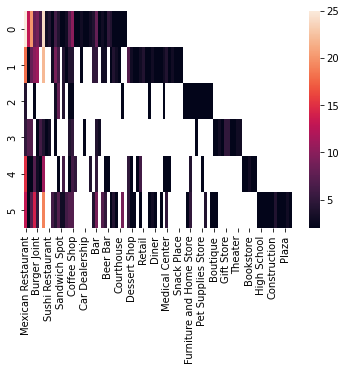

In [72]:
import seaborn as sns

sns.heatmap(data_map)